# Optimised Evaluation of MobileNetV2 and ResNet-18 on CIFAR-10 and CIFAR-100

This notebook will evaluate the performance of the two model architectures that are used in our project: MobileNetV2 and ResNet-18, using the CIFAR-10 and CIFAR-100 datasets. The evaluation is divided by dataset and includes a clear comparison between the two models.

> Key questions that we will tackle:
- Which training strategy is more effective?
- Which model performs better?
- What is the best achieved performance?
- Where do the models fail?
- What is the computational cost?

## Setup

In [1]:
import os, sys, time, torch, dataframe_image as dfi, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sb
from sklearn.metrics import classification_report, confusion_matrix
from typing import List, Optional,Literal

from pathlib import Path
ROOT = Path().resolve().parent
sys.path.insert(0, str(ROOT))

from model import TransferModel

from data_preparation.CIFAR_10.data_cifar_10 import test_loader as test_loader_10
from data_preparation.CIFAR_100.data_cifar_100 import test_loader as test_loader_100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
The size of training set is 45000 samples
The size of validation set is 5000 samples
Running on: cpu


Loading 'class_labels' from CIFAR-10 and CIFAR-100 datasets.

In [2]:
class_labels_10 = test_loader_10.dataset.classes
class_labels_100 = test_loader_100.dataset.classes

class_labels_10[:5], class_labels_100[:5]

(['airplane', 'automobile', 'bird', 'cat', 'deer'],
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver'])

Helper lists are defined for plotting purposes only.

In [3]:
strategy_labels = ['Head-Only', 'Last-Block', 'Fine-Tuning']
model_names = ['MobileNetV2', 'ResNet-18']
dataset_names = ['CIFAR-10','CIFAR-100']

Structured loading of training histories, predictions, and model weights for evaluation.

In [4]:
def load_data(dataset:Literal['CIFAR_10', 'CIFAR_100'], model_name:Literal['mobilenet_v2', 'resnet18'], device: str, class_labels: Optional[list[str]] = None):
    """
    This function loads the training histories for all transfer learning strategies, calculates the generalization gap, 
    retrieves test predictions with optional class labels, and initializes the specified model architecture with its best-performing weights.

    Returns:
        histories: dict with following keys ['Head-Only', 'Last-Block', 'Fine-Tuning'] and DataFrames as values (for Slide 1)
        [y_true, y_pred]: true labels list 'y_true' and predicted labels list 'y_pred' (for Slide 2)
        [model, weights_path]: best-performing model and its weight file path (for Conclusions)
    """

    base_path = ROOT / f"data_evaluation_{model_name}" / dataset
    
    dataset_path_name = dataset.lower().replace('_', '') # CIFAR_100 -> cifar100
    num_classes = int(dataset.replace('CIFAR_', '')) # CIFAR_100 -> 100

    # Load history for each strategy
    histories = {strategy_labels[i]: pd.read_csv(base_path / f"{model_name}_{dataset_path_name}_{s}_best_training_history.csv") for i,s in enumerate(["head","lastblock", "full"]) }
    for df in histories.values(): df['gap'] = df['val_loss'] - df['train_loss'] # calculate generalisation gap (Val Loss - Train Loss)

    # Load predictions
    preds = pd.read_csv(base_path / f"{model_name}_test_predictions.csv")
    
    if class_labels:
        # mappind IDs to class labels
        y_true = [class_labels[i] for i in preds.True_Label]
        y_pred = [class_labels[i] for i in preds.Predicted_Label]
    else:
        # leave IDs for classes
        y_true = preds['True_Label'].tolist()
        y_pred = preds['Predicted_Label'].tolist()

    # Load model structure
    model = TransferModel(num_classes=num_classes, backbone=model_name, pretrained=True).to(device)

    # Load weights
    weights_path = base_path / f"{model_name}_{dataset_path_name}_full_best.pth"
    model.load_state_dict(torch.load(weights_path, map_location=device))

    return histories, [y_true, y_pred], [model, weights_path]

Loading CIFAR-10 and CIFAR-100 data separately for each model architecture.

In [5]:
extract_df = lambda history: [history[key] for key in strategy_labels] # lambda function to extract df from each history_dict

# For CIFAR-10
mobilenet_10_history, mobilenet_10_list_pred, mobilenet_10_model = load_data("CIFAR_10", "mobilenet_v2", device, class_labels=class_labels_10)
resnet_10_history, resnet_10_list_pred, resnet_10_model = load_data("CIFAR_10", "resnet18", device,  class_labels=class_labels_10)
# Extract DataFrames from history dict (for each strategy)
history_cifar_10 = [extract_df(mobilenet_10_history), extract_df(resnet_10_history)]

# For CIFAR-100
mobilenet_100_history, mobilenet_100_list_pred, mobilenet_100_model = load_data("CIFAR_100", "mobilenet_v2", device, class_labels=class_labels_100)
resnet_100_history, resnet_100_list_pred, resnet_100_model = load_data("CIFAR_100", "resnet18", device,  class_labels=class_labels_100)
history_cifar_100 = [extract_df(mobilenet_100_history), extract_df(resnet_100_history)]

Data for Part 1 for accuracy analytics.

In [6]:
history_cifar_10[1][0].head(5)
# first index (1) stands for model (0 - MobileNetV2', 1 - ResNet-18)
# second (0) for training strategy (0 - 'Head-Only', 1 - 'Last-Block', 2 - 'Fine-Tuning')

,train_loss,val_loss,val_acc,gap
0,1.092005,0.703609,0.7628,-0.388396
1,0.892857,0.661695,0.7750,-0.231162
2,0.871607,0.646882,0.7768,-0.224724
3,0.871956,0.606633,0.7922,-0.265322
4,0.866660,0.619499,0.7818,-0.247161


Data for Part 2 for global metrics analysis.

In [7]:
for i in range(3):
    print(f'True {mobilenet_10_list_pred[0][i]} -> pred {mobilenet_10_list_pred[1][i]}')

True cat -> pred cat
True ship -> pred ship
True ship -> pred ship


Data for the Conclusion part.

In [8]:
type(mobilenet_10_model[0]), mobilenet_10_model[1]

(model.TransferModel,
 PosixPath('/Users/ira/Documents/VisualStudio/ml-cnn-transfer-learning-1/data_evaluation_mobilenet_v2/CIFAR_10/mobilenet_v2_cifar10_full_best.pth'))

This function is used for model inference and plot predictions.

In [9]:
def visualize_model_predictions(model, loader, class_labels, target_class=None, num_images=5, device="cpu", title:str=None):
    samples = []
    
    if target_class is not None:  target_class_id = class_labels.index(target_class) 
    
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in loader: 
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            # Define filter
            if target_class:
                mask = (labels == target_class_id) & (preds != target_class_id)
            else:
                mask = torch.ones_like(labels, dtype=torch.bool)
            
            # Store matching images
            if mask.any():
                for img, t, p in zip(images[mask], labels[mask], preds[mask]):
                    samples.append((img.cpu(), t.item(), p.item()))
                    if len(samples) >= num_images: break
            
            if len(samples) >= num_images: break
        
    if not samples: return print("No images found.")

    # Unnormalize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    fig, ax = plt.subplots(1, len(samples), figsize=(3 * len(samples), 4))
    if title: plt.suptitle(title)

    for i in range(num_images) :
        img_tensor, true_id, pred_id = samples[i]
        
        img = img_tensor.permute(1, 2, 0).numpy()
        img = (std * (img) + mean) 

        ax[i].axis("off")
        ax[i].set_title(f"True : {class_labels[true_id]}, Pred: {class_labels[pred_id]}",fontsize=10)
        ax[i].imshow(img)

    plt.show()

## Training & Global Metrics

                                                                            Validation Accuracy Curves                                                                                                    

In [10]:
def plot_training_analytics(list_dfs:List[List[pd.DataFrame]], model_names:List[str], ax:plt.Axes, metric:str, title:str = None, axis_labels:Optional[List[str]] = None, strategy_labels:Optional[List[str]] = None):
    """
    Helper function for plotting training metrics across multiple models and strategies.
    
    Args:
        list_dfs: outer list corresponds to a model, while inner list must contain DataFrames for each transfer learning strategy
        model_names: list of names of the models !corresponding to the outer list 'list_dfs'
        ax: matplotlib axes
        metric: column which to plot from each df from 'list_dfs'
        title: optional title for subplot
        axis_labels: optional [x_label, y_label] for axis labeling
        strategy_labels: optional list of strategy !corresponding to the inner list 'list_dfs'
    """

    linestyles = ['-',':', '--'] 
    colors = ['blue', 'orange'] 

    for model_idx, model_strategies in enumerate(list_dfs): # loop over models
        color = colors[model_idx] # for new model new color

        for strat_idx, df_strategy in enumerate(model_strategies): # loop over strategies
            linestyle = linestyles[strat_idx] # for new strategy new linestyle

            label = f"{model_names[model_idx]} ({strategy_labels[strat_idx]})" # aggregate label
            ax.plot(df_strategy.index, df_strategy[metric], label=label, linestyle=linestyle, color=color)
                
    if axis_labels: 
        ax.set_xlabel(axis_labels[0]), ax.set_ylabel(axis_labels[1])

    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend()

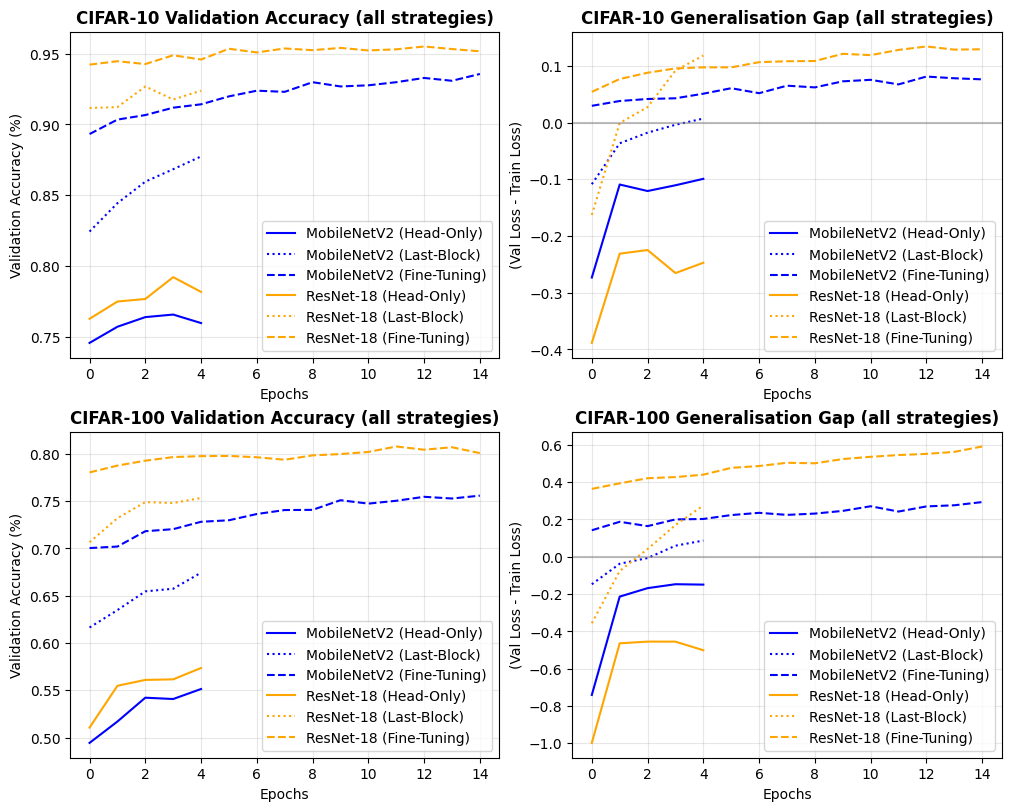

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), layout='constrained')

for i, df in enumerate([history_cifar_10, history_cifar_100]):
    plot_training_analytics(
        list_dfs = df,                   
        model_names = model_names, # ['MobileNetV2', 'ResNet-18']
        ax = ax[i,0],                       
        metric = 'val_acc',           
        title = f"{dataset_names[i]} Validation Accuracy (all strategies)",
        axis_labels = ["Epochs", "Validation Accuracy (%)"],
        strategy_labels = strategy_labels # ['Head-Only', 'Last-Block', 'Fine-Tuning']
    )

    plot_training_analytics(
        list_dfs = df,                 
        model_names = model_names,    
        ax = ax[i,1],              
        metric = 'gap',           
        title = f"{dataset_names[i]} Generalisation Gap (all strategies)",
        axis_labels = ["Epochs", "(Val Loss - Train Loss)"],
        strategy_labels = strategy_labels       
    )
    ax[i,1].axhline(y=0,color='grey' , alpha=0.5) # plot line y=0
plt.show()

> **CIFAR-10 and CIFAR-100 Validation Accuracy Graphs**
* From the validation accuracy curves, we observe a consistent ranking of training strategies: Fine-Tuning > Last-Block > Head-Only, independent of the dataset. Fine-tuning achieves the highest validation accuracy across all cases.
* CIFAR-10 reaches higher overall accuracy (approximately 95% for fine-tuned ResNet-18).
* CIFAR-100 achieves lower accuracies overall, reflecting the increased difficulty of the task.

> **CIFAR-10 and CIFAR-100 Generalisation Gap**
* for CIFAR-10 generalisation gaps are small and mostly positive for fine-tuning → mild overfitting but stable
* CIFAR-100 generalisation gaps are much larger, especially for fine-tuned ResNet-18 → stronger overfitting

> Which training strategy is more effective? **Full fine-tuning**

> Which model performs better? **ResNet-18**

                                                                            Max Validation Accuracy Barplot                                                                                                    

Collect all the information from training with different transfer learning strategies into one single DataFrame in order to plot it.

In [12]:
lr_map = {'Head-Only': 0.001, 'Last-Block': 0.0001, 'Fine-Tuning': 0.00001}
summary_data_list = []

for dataset_idx, history_by_dataset in enumerate([history_cifar_10, history_cifar_100]): # Loop over datasets
    for strategy_idx, model_dfs in enumerate(zip(*history_by_dataset)): # *history_by_dataset -> [strategy_1_models, strategy_2_models, strategy_3_models]

        current_strategy = strategy_labels[strategy_idx]
        current_lr = lr_map.get(current_strategy, 0.00001)
        
        for model_idx, df in enumerate(model_dfs): # Loop over strategies ['Head-Only', 'Last-Block', 'Fine-Tuning']
            max_acc_pct = df['val_acc'].max() * 100 # calculate percentage max val acc
        
            summary_data_list.append([
                current_strategy, #Training Strategy
                model_names[model_idx], #Model  
                max_acc_pct, #Maximum Val Accuracy               
                len(df), #Epochs                        
                'Imagenet', #Initial Weights                   
                dataset_names[dataset_idx], #Dataset                
                current_lr  #Learning Rate                    
            ])
summary_table = pd.DataFrame(summary_data_list, columns=[
    'Training Strategy', 'Model', 'Maximum Val Accuracy', 
    'Epochs', 'Initial Weights', 'Dataset', 'Learning Rate'
])

#style to display
styled_global = summary_table.style.format({
    'Maximum Val Accuracy': '{:.2f}%',
    'Learning Rate': '{:.5f}' 
}).hide(axis='index')

display(styled_global)

Training Strategy,Model,Maximum Val Accuracy,Epochs,Initial Weights,Dataset,Learning Rate
Head-Only,MobileNetV2,76.58%,5,Imagenet,CIFAR-10,0.00100
Head-Only,ResNet-18,79.22%,5,Imagenet,CIFAR-10,0.00100
Last-Block,MobileNetV2,87.74%,5,Imagenet,CIFAR-10,0.00010
Last-Block,ResNet-18,92.68%,5,Imagenet,CIFAR-10,0.00010
Fine-Tuning,MobileNetV2,93.56%,15,Imagenet,CIFAR-10,0.00001
Fine-Tuning,ResNet-18,95.50%,15,Imagenet,CIFAR-10,0.00001
Head-Only,MobileNetV2,55.14%,5,Imagenet,CIFAR-100,0.00100
Head-Only,ResNet-18,57.36%,5,Imagenet,CIFAR-100,0.00100
Last-Block,MobileNetV2,67.44%,5,Imagenet,CIFAR-100,0.00010
Last-Block,ResNet-18,75.34%,5,Imagenet,CIFAR-100,0.00010


In [13]:
def plot_max_acc_bar_plot(summary_table, dataset, ax, title):
    """
    This function plots the maximum validation accuracy per model across training strategies, with percentage labels on the bars
    """
    ax = sb.barplot(data=summary_table[summary_table['Dataset']==dataset], x="Training Strategy", y="Maximum Val Accuracy", hue="Model", ax=ax)

    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', padding=5) # add percentage on top of bars

    ax.set_title(title) 
    ax.set_ylabel("Max Val Accuracy (%)")
    ax.set_xlabel('Training strategy')

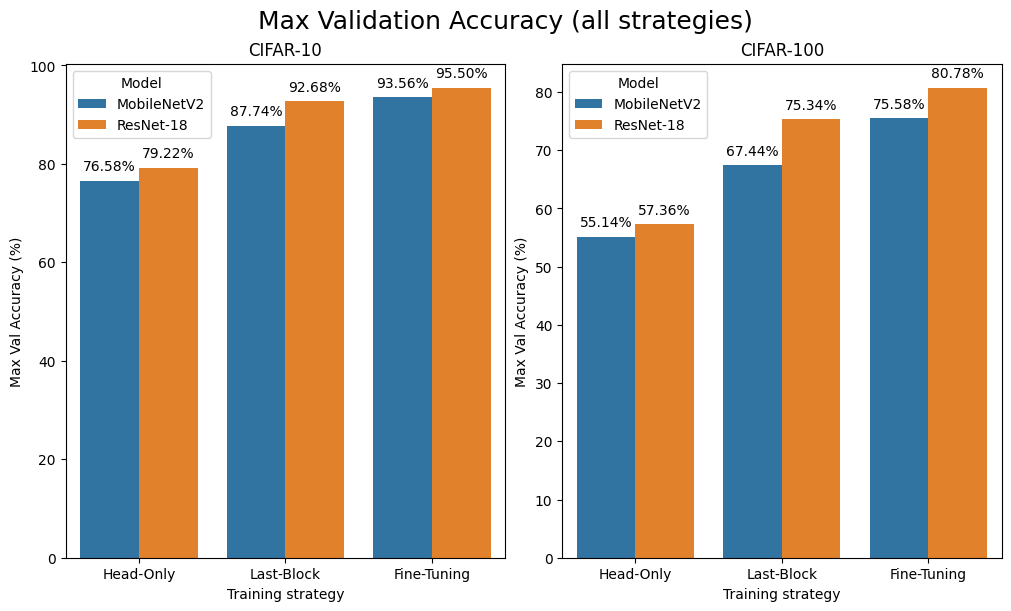

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), layout='constrained') 

plt.suptitle("Max Validation Accuracy (all strategies)", fontsize=18)
for i,data_name in enumerate(dataset_names):
    plot_max_acc_bar_plot(summary_table,data_name, ax[i], data_name)
plt.show()

                                                                            Global metrics table                                                                                                    

To collect global metrics, the classification_report function from sklearn.metrics was used. The reports were generated for each case.

In [15]:
# for CIFAR-100
report_mobilinet_10 = classification_report(mobilenet_10_list_pred[0], mobilenet_10_list_pred[1], output_dict=True)
report_resnet_10 = classification_report(resnet_10_list_pred[0], resnet_10_list_pred[1], output_dict=True)

# for CIFAR-100
report_mobilinet_100 = classification_report(mobilenet_100_list_pred[0], mobilenet_100_list_pred[1], output_dict=True)
report_resnet_100 = classification_report(resnet_100_list_pred[0], resnet_100_list_pred[1], output_dict=True)

Then collect metrics accuracy, recall, and F1-score for each model and dataset configuration into one DataFrame.

In [16]:
def extract_global_metrics(report, model_name, dataset_name):
    """
    Function takes a classification report dictionary, a model name, and a dataset identifier
    returns a summarized dictionary containing the model, dataset, accuracy, macro F1, weighted F1, and macro recall
    """
    return {
        'Model': model_name,
        'Data': dataset_name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score']
    }

In [17]:
metrics_data = [
    extract_global_metrics(report_mobilinet_10, 'MobileNetV2', 'CIFAR10'),
    extract_global_metrics(report_resnet_10,'ResNet-18' , 'CIFAR10'),
    extract_global_metrics(report_mobilinet_100, 'MobileNetV2', 'CIFAR100'),
    extract_global_metrics(report_resnet_100,'ResNet-18', 'CIFAR100' )
]

df_global_metrics = pd.DataFrame(metrics_data)

#stylised version
styled_global = df_global_metrics.style.format({
    'Accuracy': '{:.2%}',
    'Macro F1': '{:.2%}',
    'Weighted F1': '{:.2%}',
}).hide(axis='index')

display(styled_global)

Model,Data,Accuracy,Macro F1,Weighted F1
MobileNetV2,CIFAR10,93.23%,93.24%,93.24%
ResNet-18,CIFAR10,94.83%,94.82%,94.82%
MobileNetV2,CIFAR100,75.89%,75.87%,75.87%
ResNet-18,CIFAR100,80.22%,80.22%,80.22%


> Accuracy -> overall percentage of correctly classified samples
* CIFAR-10: ResNet-18 slightly outperforms MobileNetV2 showing better overall performance
* CIFAR-100: ResNet-18 also performs better.

> Macro F1 → The harmonic mean of precision and recall, calculated equally across all classes regardless of their frequency

This metric reflects the model’s ability to balance precision and recall for each class, without giving more weight to classes with more samples.

> Weighted F1 → Similar to Macro F1, but weighted by the number of samples in each class. 

It accounts for class imbalance, giving more influence to classes with more samples.

We can observe from the table above that Macro F1 vs Weighted F1 are identical, indicating that the datasets are relatively balanced, so class distribution does not heavily skew the results.

> What is the best achieved performance?
<br>**CIFAR-10** -> ResNet-18 achieves the highest overall performance with 94.83% accuracy, 94.82% macro F1, and 94.82% weighted F1
<br>**CIFAR-100** -> ResNet-18 again performs best with 80.22% accuracy, 80.22% macro F1, and 80.22% weighted F1

## Slide 2: Error Analysis + Efficiency

To collect global metrics, the 'classification_report' function from sklearn.metrics was used.

In [18]:
report_mobilinet_10 = classification_report(mobilenet_10_list_pred[0], mobilenet_10_list_pred[1], output_dict=True)
report_resnet_10 = classification_report(resnet_10_list_pred[0], resnet_10_list_pred[1], output_dict=True)
report_mobilinet_100 = classification_report(mobilenet_100_list_pred[0], mobilenet_100_list_pred[1], output_dict=True)
report_resnet_100 = classification_report(resnet_100_list_pred[0], resnet_100_list_pred[1], output_dict=True)

In [19]:
def process_classification_reports(reports, model_names):
    """
    Helper function to transform dict from 'classification_report' to DataFrame
    """
    df_list = []

    for report, model_name in zip(reports, model_names):

        temp_df = pd.DataFrame(report).transpose().reset_index() # get class_labels not as dict key but as column
        temp_df = temp_df.rename(columns={'index': 'Class Label'}) # rename columns
        temp_df['Model'] = model_name # add model indentificator
        df_list.append(temp_df)

    df_result = pd.concat(df_list, ignore_index=True)

    # remove general metrics
    summary_columns = ['accuracy', 'macro avg', 'weighted avg']
    df_result = df_result[~df_result['Class Label'].isin(summary_columns)] # selects all columns where 'Class Label' != summary_columns
    df_result = df_result.reset_index(drop=True)

    # scale data to have in range 0-100
    cols_to_scale = ['precision', 'recall', 'f1-score']
    df_result[cols_to_scale] = df_result[cols_to_scale] * 100

    return df_result

Prepare data for bar plot for the CIFAR-10 dataset.

In [20]:
report_df_cifar_10 = process_classification_reports([report_mobilinet_10, report_resnet_10], model_names)
report_df_cifar_10.head(5)

,Class Label,precision,recall,f1-score,support,Model
0,airplane,94.388778,94.2,94.294294,1000.0,MobileNetV2
1,automobile,96.576032,95.9,96.236829,1000.0,MobileNetV2
2,bird,95.729167,91.9,93.775510,1000.0,MobileNetV2
3,cat,85.300000,85.3,85.300000,1000.0,MobileNetV2
4,deer,92.430279,92.8,92.614770,1000.0,MobileNetV2


For the CIFAR-100 dataset.

In [21]:
report_df_cifar_100 = process_classification_reports([report_mobilinet_100, report_resnet_100], model_names)
report_df_cifar_100.head(5)

,Class Label,precision,recall,f1-score,support,Model
0,apple,94.845361,92.0,93.401015,100.0,MobileNetV2
1,aquarium_fish,86.407767,89.0,87.684729,100.0,MobileNetV2
2,baby,70.652174,65.0,67.708333,100.0,MobileNetV2
3,bear,71.590909,63.0,67.021277,100.0,MobileNetV2
4,beaver,53.571429,60.0,56.603774,100.0,MobileNetV2


                                                                            Per-Class Performance Analytics                                                                                                    

Plotting all metrics from the tables above would be redundant. For per-class evaluation, it is sufficient to analyze the F1-score, as it incorporates both precision and recall and provides a more informative measure, whereas accuracy alone can be misleading.

In [22]:
def plot_class_analytics(df, ax, metric:str, interval:List[int]=None, title:str=None, axis_labels:List[str]=None, percentage:bool=False, order=None):  
    """
    Function creates a bar plot of a specified metric per class.
    """
    ax = sb.barplot(data=df, x="Class Label", y=metric, hue = "Model" if "Model" in df.columns else None, ax=ax,order=order) #palette='viridis'
  
    if df.shape[0]>20: ax.tick_params(axis='x', rotation=90, labelsize=6)

    if axis_labels: ax.set_xlabel(axis_labels[0]), ax.set_ylabel(axis_labels[1])
    if percentage: 
        for container in ax.containers: ax.bar_label(container, fmt='%.1f%%', padding=5) # add percentage on top of bars
    if title: ax.set_title(title)
    if interval: ax.set_ylim(interval[0], interval[1])

In [23]:
def compute_f1_diff(df_result, model_names):
    """
    Compute per-class F1-score differences between model_names[1] (ResNet) and model_names[0] (MobileNet)
    """

    df_wide = df_result.pivot(index='Class Label', columns='Model', values='f1-score')  # pivot to wide format
    df_wide['diff'] = df_wide[model_names[1]] - df_wide[model_names[0]]
    return df_wide

### For CIFAR-10

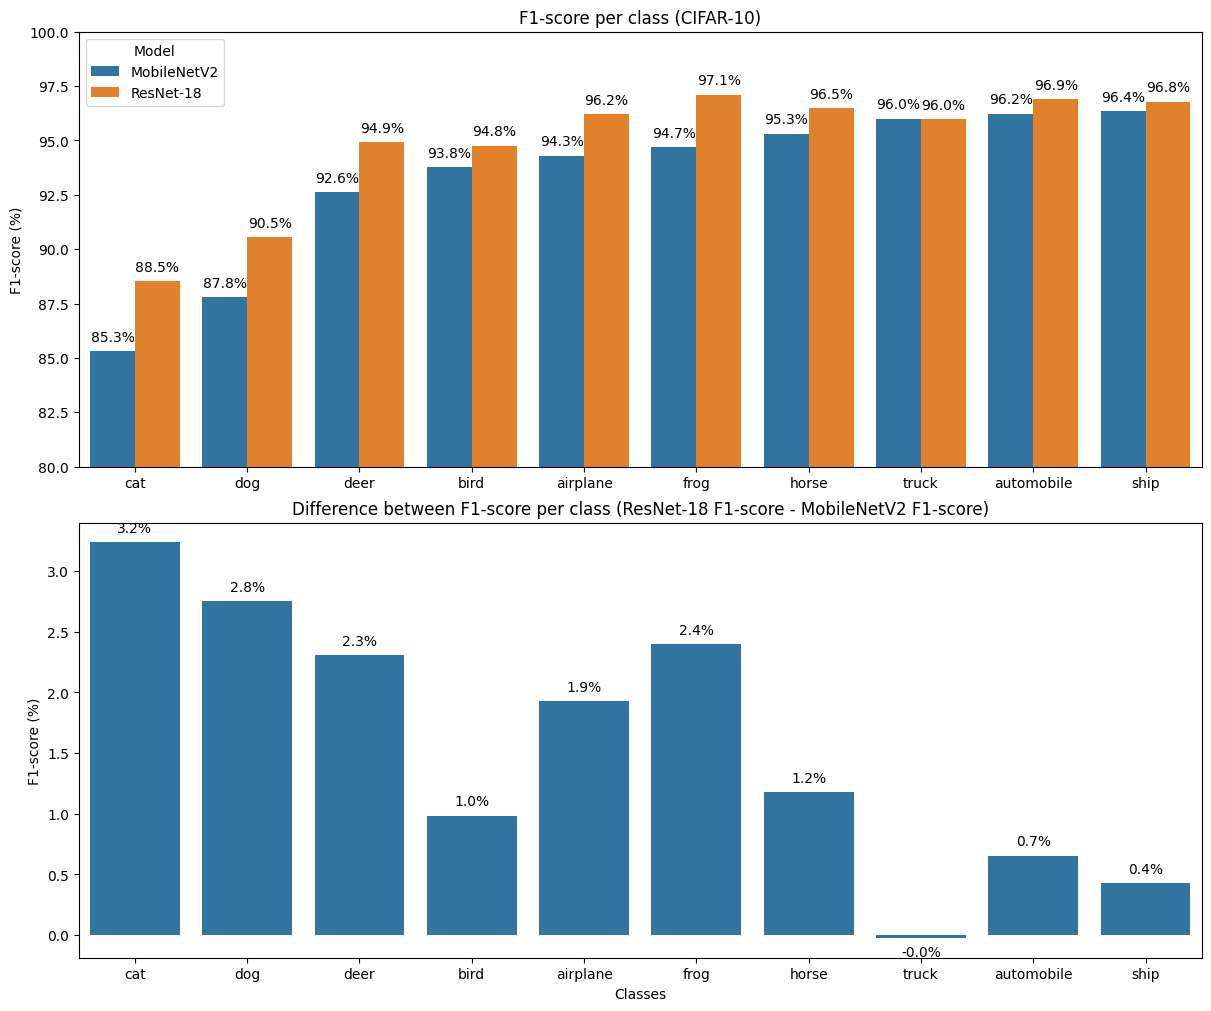

In [24]:
# receive index list of the worst performing class (average for two model architectures) to the best one
sort_classes = report_df_cifar_10.groupby('Class Label')['f1-score'].mean().sort_values().index

fig, ax = plt.subplots(2,1,figsize=(12, 10), layout="constrained") #(12, 15)

# plot F1-score
plot_class_analytics(report_df_cifar_10, ax[0], 'f1-score', title='F1-score per class (CIFAR-10)', interval=[80,100], axis_labels=['','F1-score (%)'], order=sort_classes, percentage=True)

# plot F1-score as difference between ResNet performance and MobileNet
#       If positive -> ResNet better
#       If negative -> MobileNet better
plot_class_analytics(compute_f1_diff(report_df_cifar_10, model_names), ax[1], 'diff', title='Difference between F1-score per class (ResNet-18 F1-score - MobileNetV2 F1-score)', axis_labels=['Classes','F1-score (%)'], order=sort_classes, percentage=True)

plt.show()

                                                                            Top 5 Confusion Pair for CIFAR-10                                                                                                    

Computes the confusion matrix for the predictions of MobileNetV2 and ResNet-18 on the CIFAR-10 dataset.
> The confusion matrix shows how many samples from each true class were correctly or incorrectly predicted, highlighting per-class model errors.

In [25]:
mobilinet_10_overall_confusion_matrix = confusion_matrix(mobilenet_10_list_pred[0], mobilenet_10_list_pred[1]) #,normalize='true'
resnet_10_overall_confusion_matrix = confusion_matrix(resnet_10_list_pred[0], resnet_10_list_pred[1]) #,normalize='true'

In [26]:
def get_top_confusions(cm_: np.ndarray, class_labels: list[str], top_n: int = 5, model:str = '') -> pd.DataFrame:
    """
    Returns a DataFrame of the top N confusion pairs (most frequent misclassifications).
    
    Args:
        cm_ : confusion matrix (numpy array)
        class_labels : list of class names corresponding to cm_ rows/columns
        top_n : number of top confusions to return
        model : optional model name for labeling
    
    Returns:
        pd.DataFrame with columns: ['True Class', 'Predicted Class', 'Count']
    """
    
    cm = cm_.copy()
    np.fill_diagonal(cm, 0)  # ignore correct predictions
    
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                pairs.append((f'{class_labels[i]} -> {class_labels[j]}',cm[i, j],class_labels[i], class_labels[j])) # *100
    
    df = pd.DataFrame(pairs, columns=['Confusion Pair', 'Count', 'True Class', 'Predicted Class'])
    df = df.sort_values('Count', ascending=False).iloc[:top_n].reset_index(drop=True)
    if model: df.insert(0, 'Model', model)
    
    return df

In [27]:
list_top_confusions = [
    get_top_confusions(mobilinet_10_overall_confusion_matrix, model='MobileNetV2', class_labels=class_labels_10, top_n=5),
    get_top_confusions(resnet_10_overall_confusion_matrix, model='ResNet-18', class_labels=class_labels_10, top_n=5)
]

df_top_confusions_10 = pd.concat(list_top_confusions).sort_values(by=['True Class','Predicted Class','Model']).reset_index(drop=True)
df_top_confusions_10.style.hide(axis='index')

Model,Confusion Pair,Count,True Class,Predicted Class
ResNet-18,airplane -> ship,20,airplane,ship
MobileNetV2,automobile -> truck,24,automobile,truck
ResNet-18,automobile -> truck,27,automobile,truck
MobileNetV2,cat -> dog,80,cat,dog
ResNet-18,cat -> dog,89,cat,dog
MobileNetV2,cat -> frog,26,cat,frog
MobileNetV2,dog -> cat,76,dog,cat
ResNet-18,dog -> cat,40,dog,cat
MobileNetV2,truck -> automobile,22,truck,automobile
ResNet-18,truck -> automobile,23,truck,automobile


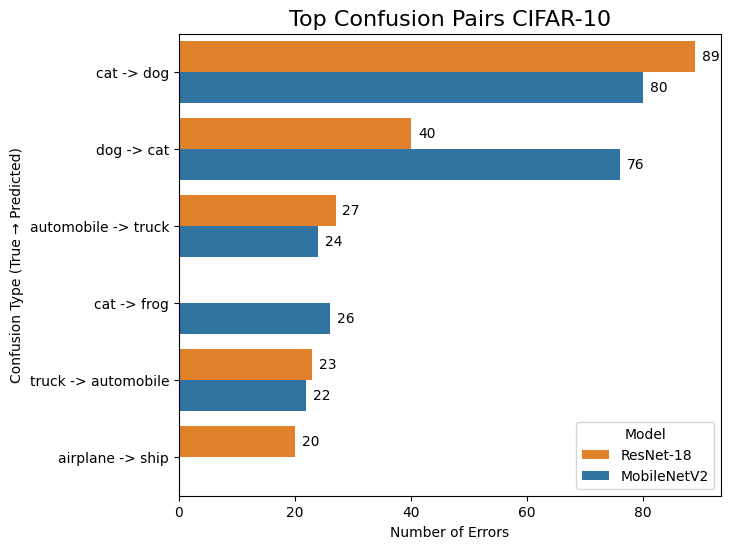

In [28]:
plt.figure(figsize=(7, 6))

ax = sb.barplot(
    data=df_top_confusions_10.sort_values('Count', ascending=False), 
    x="Count", 
    y="Confusion Pair", 
    hue="Model", 
    palette={'ResNet-18': '#ff7f0e', 'MobileNetV2': '#1f77b4'}
)

for container in ax.containers:
    ax.bar_label(container, padding=5) # add percentage on top of bars
    

plt.title("Top Confusion Pairs CIFAR-10", fontsize=16)
plt.xlabel("Number of Errors")
plt.ylabel("Confusion Type (True → Predicted)")
plt.legend(title='Model')

plt.show()

> Top confusions
* The most confused pair: cat <-> dog and automobile -> truck.
* Overall we can see that both ResNet-18 and MobileNetV2 confuse similar classes, but the magnitude of misclassification differs.

> Model Comparison
* ResNet-18 tends to make fewer confusions on some pairs (dog -> cat) but more on others (cat -> dog).
* MobileNetV2 shows more distributed errors across multiple classes, suggesting slightly lower per-class discrimination.

> Where do the models fail? 
<br>Both ResNet-18 and MobileNetV2 struggle with similar class pairs, indicating common weaknesses in distinguishing certain categories.


CIFAR-10 the most confused class **'cat'**.


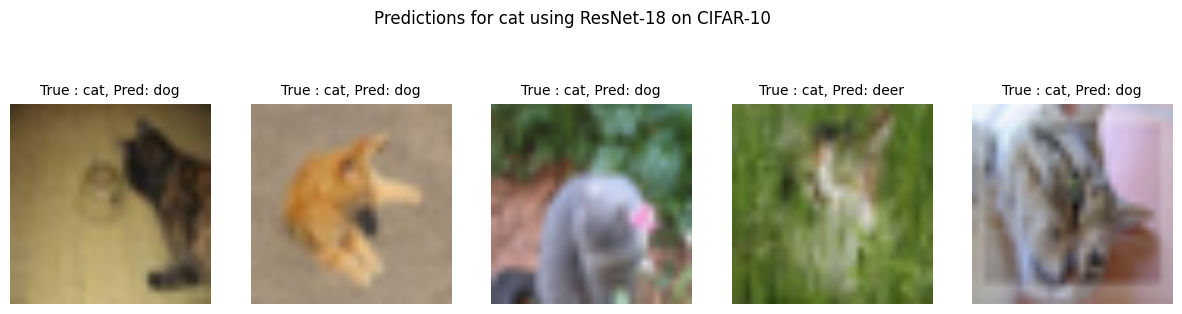

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000076293944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04313725280761721..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.7418136649970393e-09..1.0000000076293944].


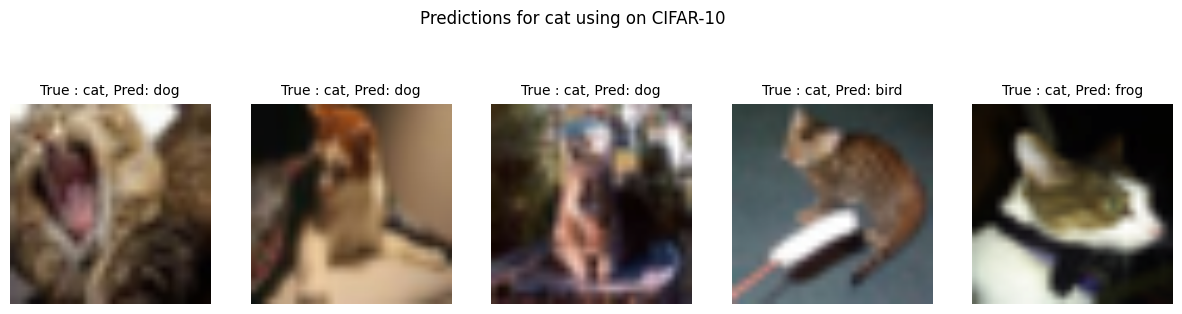

In [29]:
target_class='cat'

visualize_model_predictions(resnet_10_model[0], test_loader_10, class_labels=class_labels_10, target_class=target_class, title=f'Predictions for {target_class} using ResNet-18 on CIFAR-10')
visualize_model_predictions(mobilenet_10_model[0], test_loader_10, class_labels=class_labels_10, target_class=target_class, title=f'Predictions for {target_class} using on CIFAR-10')

### For CIFAR-100

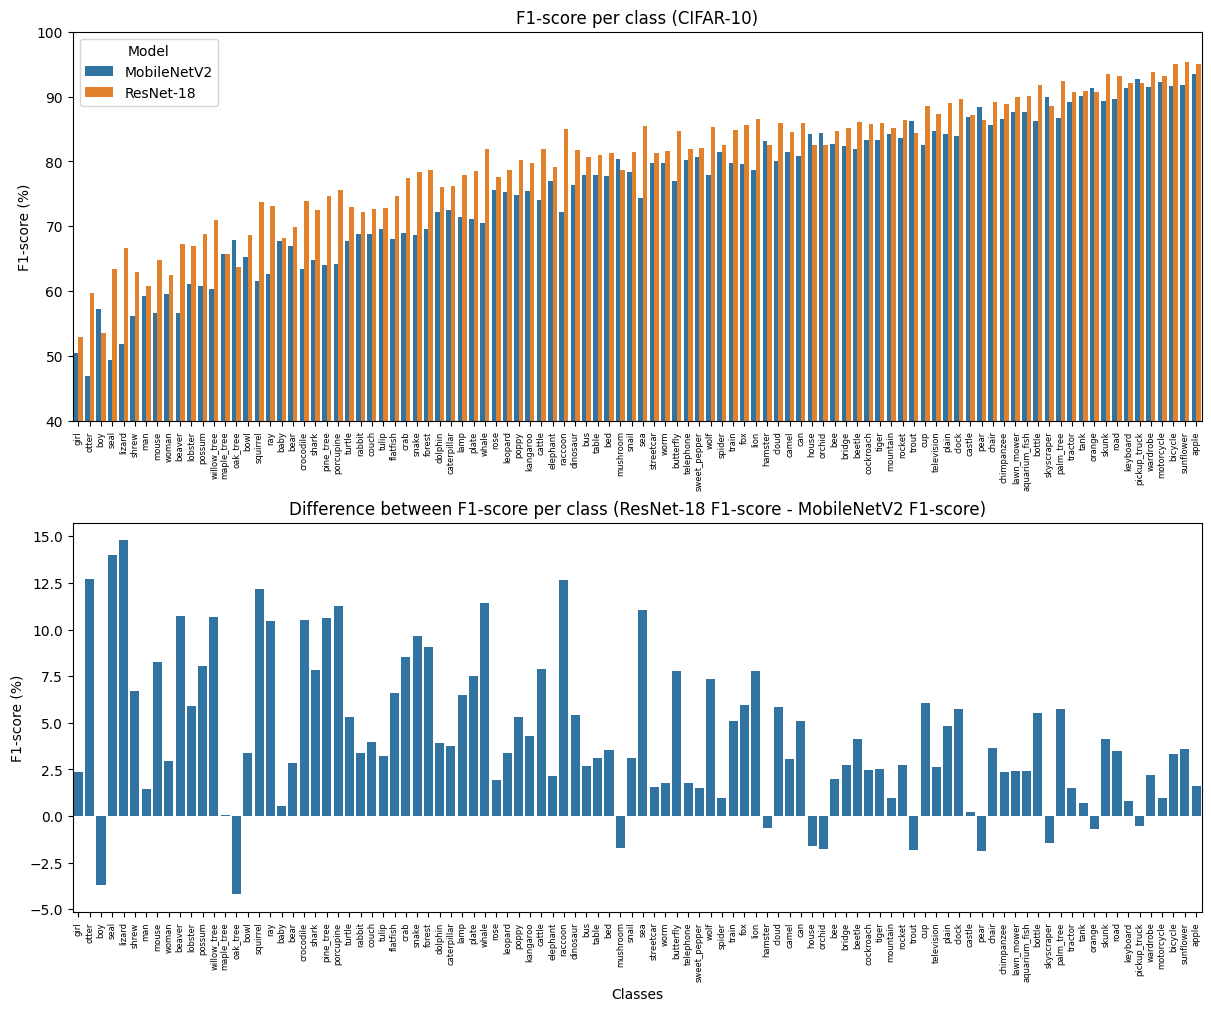

In [30]:
# receive index list of the worst performing class (average for two model architectures) to the best one
sort_classes = report_df_cifar_100.groupby('Class Label')['f1-score'].mean().sort_values().index

fig, ax = plt.subplots(2, 1, figsize=(12, 10), layout="constrained") #(12, 15)

# plot F1-score
plot_class_analytics(report_df_cifar_100, ax[0], 'f1-score', title='F1-score per class (CIFAR-10)', interval=[40,100], axis_labels=['','F1-score (%)'], order=sort_classes)

# plot F1-score as difference between ResNet performance and MobileNet
#       If positive -> ResNet better
#       If negative -> MobileNet better
plot_class_analytics(compute_f1_diff(report_df_cifar_100, model_names), ax[1], 'diff', title='Difference between F1-score per class (ResNet-18 F1-score - MobileNetV2 F1-score)', axis_labels=['Classes','F1-score (%)'], order=sort_classes)

plt.show()

                                                                            Top 5 Confusion Pair for CIFAR-100                                                                                                    

In [31]:
mobilinet_100_overall_confusion_matrix = confusion_matrix(mobilenet_100_list_pred[0], mobilenet_100_list_pred[1]) #,normalize='true'
resnet_100_overall_confusion_matrix = confusion_matrix(resnet_100_list_pred[0], resnet_100_list_pred[1]) #,normalize='true'

In [32]:
list_top_confusions = [
    get_top_confusions(mobilinet_100_overall_confusion_matrix, model='MobileNetV2', class_labels=class_labels_100, top_n=5),
    get_top_confusions(resnet_100_overall_confusion_matrix, model='ResNet-18', class_labels=class_labels_100, top_n=5)
]

df_top_confusions_100 = pd.concat(list_top_confusions).sort_values(by=['True Class','Predicted Class','Model']).reset_index(drop=True)
df_top_confusions_100.style.hide(axis='index')

Model,Confusion Pair,Count,True Class,Predicted Class
ResNet-18,baby -> boy,14,baby,boy
MobileNetV2,boy -> man,18,boy,man
MobileNetV2,girl -> woman,18,girl,woman
ResNet-18,girl -> woman,20,girl,woman
ResNet-18,man -> boy,17,man,boy
MobileNetV2,maple_tree -> oak_tree,17,maple_tree,oak_tree
ResNet-18,maple_tree -> oak_tree,18,maple_tree,oak_tree
ResNet-18,oak_tree -> maple_tree,19,oak_tree,maple_tree
MobileNetV2,seal -> otter,19,seal,otter
MobileNetV2,woman -> girl,18,woman,girl


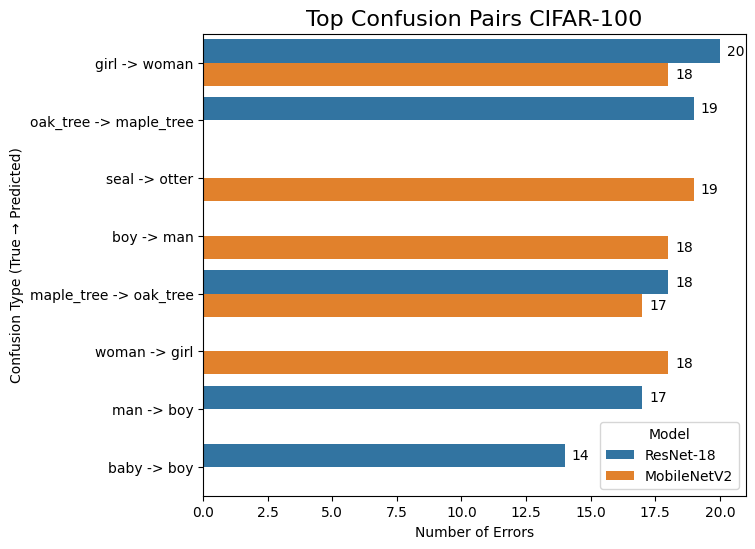

In [33]:
plt.figure(figsize=(7, 6))

ax = sb.barplot(
    data=df_top_confusions_100.sort_values('Count', ascending=False), 
    x="Count", 
    y="Confusion Pair", 
    hue="Model", 
)

for container in ax.containers:
    ax.bar_label(container, padding=5) # add percentage on top of bars
    
plt.title("Top Confusion Pairs CIFAR-100", fontsize=16)
plt.xlabel("Number of Errors")
plt.ylabel("Confusion Type (True → Predicted)")
plt.legend(title='Model')

plt.show()

> Top confusions
* The confusion pairs mainly involve semantically similar classes, such as human-related confusions (e.g., girl → woman, boy → man) and nature-related misclassifications (e.g., maple_tree ↔ oak_tree).

> Model Comparison
* ResNet-18 shows slightly more errors on fine-grained visual distinctions like oak_tree -> maple_tree and girl -> woman.
* MobileNetV2 shows more distributed errors across human-related classes (boy -> man, woman -> girl) and some animals (seal -> otter).

> Where do the models fail? 
<br>Both ResNet-18 and MobileNetV2 struggle with classes that are visually or semantically similar, showing that fine-grained distinctions are challenging.

CIFAR-100 the most confused class **'girl'**.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3294117566347122..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.011764687061309786..1.0000000236034394].


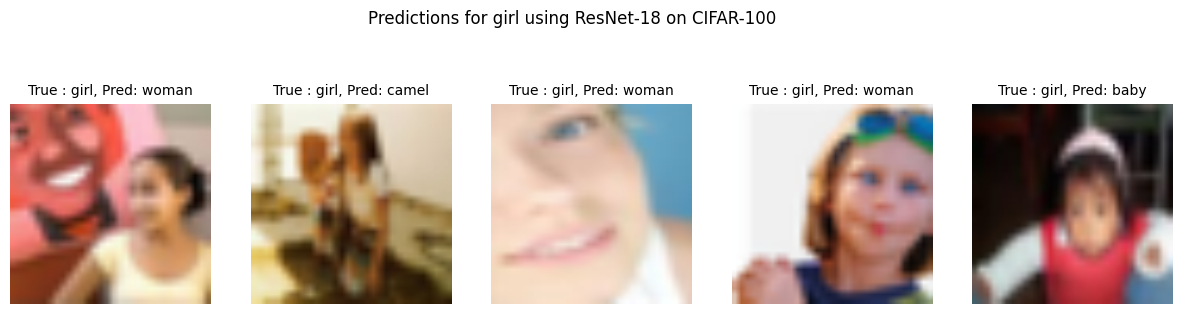

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.3294117566347122..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.053115898461357e-09..1.0000000236034394].


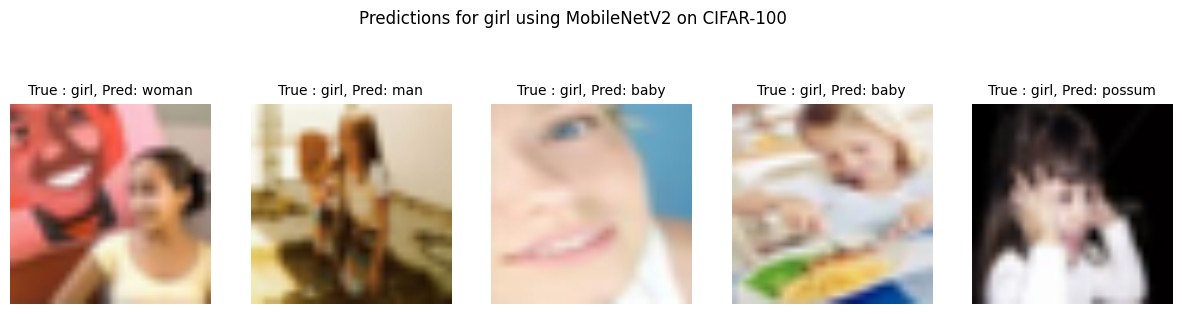

In [34]:
target_class='girl'

visualize_model_predictions(resnet_100_model[0], test_loader_100, class_labels=class_labels_100, target_class=target_class, title=f'Predictions for {target_class} using ResNet-18 on CIFAR-100')
visualize_model_predictions(mobilenet_100_model[0], test_loader_100, class_labels=class_labels_100, target_class=target_class, title=f'Predictions for {target_class} using MobileNetV2 on CIFAR-100')

## Conclusion Slide: Efficiency Analysis

In [35]:
def get_efficiency_metrics(model, loader, device, model_path, model_name):
    model.eval()

    #model size
    size_mb = os.path.getsize(model_path) / (1024 * 1024)

    #total numb of parameters
    params = sum(p.numel() for p in model.parameters())
    
    num_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)
            num_samples += images.size(0)
            
            if i >= 10: break 
            
    end_time = time.time()
    avg_inference_time = (end_time - start_time) / num_samples
    df=[]
    df.append([model_name,'CIFAR-100',size_mb,params,avg_inference_time])
    return pd.DataFrame(df,columns=['Model', 'Data','Model Size','Total Params','Inference Time (s)'])

df_res_10 = get_efficiency_metrics(resnet_10_model[0], test_loader_10, device, resnet_10_model[1],
    'ResNet-18') 
df_mobi_10= get_efficiency_metrics(mobilenet_10_model[0], test_loader_10, device, mobilenet_10_model[1],
    'MobileNetV2'
)
df_res_100 = get_efficiency_metrics(resnet_100_model[0], test_loader_10, device, resnet_100_model[1],
    'ResNet-18') 
df_mobi_100= get_efficiency_metrics(mobilenet_100_model[0], test_loader_10, device, mobilenet_10_model[1],
    'MobileNetV2'
)

df_eff= pd.concat([df_mobi_10,df_res_10,df_mobi_100,df_res_100]).reset_index(drop=True)
df_eff.style.hide(axis='index')

Model,Data,Model Size,Total Params,Inference Time (s)
MobileNetV2,CIFAR-100,8.775284,2236682,0.022597
ResNet-18,CIFAR-100,42.733238,11181642,0.023451
MobileNetV2,CIFAR-100,8.775284,2351972,0.022761
ResNet-18,CIFAR-100,42.909923,11227812,0.022525


> Model size and parameters

The two models differ significantly in size and number of parameters. MobileNetV2 is substantially smaller than ResNet-18, with a model size of approximately 8.8 MB compared to 43 MB for ResNet-18. In addition, MobileNetV2 has roughly five times fewer parameters, making it a much more lightweight architecture. As a result, MobileNetV2 is well suited for resource-constrained environments where model size and computational efficiency are critical.

> Inference time

When comparing inference time, we observe that despite their different model sizes, MobileNetV2 and ResNet-18 achieve very similar performance. MobileNetV2 requires approximately 0.022 s per batch, while ResNet-18 takes about 0.023 s per batch. This demonstrates that MobileNetV2 delivers inference speed comparable to ResNet-18 while requiring significantly lower computational resources, making it a more efficient choice for deployment in resource-constrained settings.

> Implication

MobileNetV2 is highly efficient and well suited for resource-constrained environments such as edge devices and real-time applications, whereas ResNet-18, despite being slightly heavier, may be preferred when achieving higher accuracy is the primary objective.

## Conclusions

> **Training Strategy**

* For all datasets and model architecture, full fine-tuning consistently outperformed last-block and head-only strategy.

* Fine-tuning enabled better feature adaptation for CIFAR-100 dataset.

> **Model Performance**
* ResNet-18 shows best results for CIFAR-10 ~94.8% accuracy and for CIFAR-100 ~80.2%.

> **Generalization and Overfitting**
* CIFAR-10 showed small and stable generalization gaps for both models.
* CIFAR-100 exhibited larger gaps, particularly for fine-tuned ResNet-18, indicating increased overfitting risk on harder, fine-grained classification tasks.

> **Error Analysis**

* Both models struggled with visually and semantically similar classes:
<br>CIFAR-10: cat ↔ dog, automobile ↔ truck
<br>CIFAR-100: girl ↔ woman, oak_tree ↔ maple_tree

* ResNet-18 generally showed stronger per-class classification.

> **Efficiency Cost**

* MobileNetV2 is significantly more efficient:
<br>~5× fewer parameters
<br>~5× smaller model size

#### Overall Conclusion
-> **accuracy**: ResNet-18 with full fine-tuning
<br>-> **efficiency**: MobileNetV2 with minimal performance sacrifice